# Decompose the SSH into manometric and steric components
## $\eta = \eta_m + \eta_s = \frac{p_b}{\rho_0 g} - \frac{1}{\rho_0}\int_{-H}^0{\rho'}dz $

In [1]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import ecco_v4_py.ecco_access as ea

from scipy.stats import linregress
import fsspec
import zarr

import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
import gsw

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials
    

In [3]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

In [4]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True);

In [5]:
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native')
# mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_snap_native')
# different prefixes on s3
# MZZ_day_mean_latlon
# MZZ_day_mean_native
# MZZ_mon_mean_latlon
# MZZ_mon_mean_native
# MZZ_snap_native

In [6]:
# show they are on the local disk 
np.sort(list(mzz_local_directory.glob('*json')))

array([PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_latlon_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/ATM_SURFACE_TEMP_HUM_WIND_PRES_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/ICE_FRONT_FLUX_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/ICE_SHELF_FLUX_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_3D_MOMENTUM_ADV_TEND_X_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_3D_MOMENTUM_ADV_TEND_Y_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_3D_MOMENTUM_DISS_TEND_X_mon_mean_native_llc090_ECCOV4r5.json'),
       PosixPath('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_3D_MOMENTUM_DISS_TEND_Y_mon_me

In [7]:
# MZZ files have been downloaded. 
# select the SSH dataset
TS_file = mzz_local_directory / 'OCEAN_TEMPERATURE_SALINITY_mon_mean_native_llc090_ECCOV4r5.json'
DEN_file = mzz_local_directory / 'OCEAN_DENS_STRAT_PRESS_mon_mean_native_llc090_ECCOV4r5.json'
PRE_file = mzz_local_directory / 'OCEAN_BOTTOM_PRESSURE_mon_mean_native_llc090_ECCOV4r5.json'
SSH_file = mzz_local_directory / 'SEA_SURFACE_HEIGHT_mon_mean_native_llc090_ECCOV4r5.json'

print(TS_file)
print(DEN_file)
print(PRE_file)
print(SSH_file)

/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_TEMPERATURE_SALINITY_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_DENS_STRAT_PRESS_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/OCEAN_BOTTOM_PRESSURE_mon_mean_native_llc090_ECCOV4r5.json
/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native/SEA_SURFACE_HEIGHT_mon_mean_native_llc090_ECCOV4r5.json


## load grid

In [8]:
grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
access_mode = 'download'

# download root (parent) directory
grid_fnm = '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ds_grid = xr.open_dataset(grid_fnm)
ds_grid

<xarray.Dataset> Size: 92MB
Dimensions:                 (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50,
                             k_l: 50, k_p1: 51, tile: 13, nbh: 4, nv: 2)
Coordinates: (12/20)
  * i                       (i) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * i_g                     (i_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j                       (j) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j_g                     (j_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * k                       (k) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * k_u                     (k_u) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
    ...                      ...
    Zp1                     (k_p1) float32 204B ...
    Zu                      (k_u) float32 200B ...
    Zl                      (k_l) float32 200B ...
    XC_bnds                 (tile, j, i, nbh) float32 2MB ...
    YC_bnds                 (tile, j, i, nbh) float32 2MB ...
    Z_bnds                  (k, nv) float32 400B ...
Dimensions without coordinates: nbh, nv
Data variables: (12/29)
    CS                      (tile, j, i) float32 421kB ...
    SN                      (tile, j, i) float32 421kB ...
    rA                      (tile, j, i) float32 421kB ...
    dxG                     (tile, j_g, i) float32 421kB ...
    dyG                     (tile, j, i_g) float32 421kB ...
    Depth                   (tile, j, i) float32 421kB ...
    ...                      ...
    dyF                     (tile, j, i) float32 421kB ...
    dyU                     (tile, j_g, i_g) float32 421kB ...
    rLowC                   (tile, j, i) float32 421kB ...
    rSurfC                  (tile, j, i) float32 421kB ...
    ocean_column_thickness  (tile, j, i) float32 421kB ...
    ice_shelf_draft         (tile, j, i) float32 421kB ...
Attributes: (12/61)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    source:                          The ECCO state estimate was produced by ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters - llc90 Grid (V...
    uuid:                            ef749a0c-e985-11ed-a16e-0242ac110002
    coordinates_comment:             Note: the global 'coordinates' attribute...

# 1. read data (all times), SSH, pressure, density, T/S

In [9]:
fs_TS = fsspec.filesystem("reference",     
                       fo=str(TS_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_TS.asynchronous = True
store = zarr.storage.FsspecStore(fs_TS)
ds_TS = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 

# 
fs_DEN = fsspec.filesystem("reference",     
                       fo=str(DEN_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_DEN.asynchronous = True
store = zarr.storage.FsspecStore(fs_DEN)
ds_DEN = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 


fs_PRE = fsspec.filesystem("reference",     
                       fo=str(PRE_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_PRE.asynchronous = True
store = zarr.storage.FsspecStore(fs_PRE)
ds_PRE = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 


fs_SSH = fsspec.filesystem("reference",     
                       fo=str(SSH_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
fs_SSH.asynchronous = True
store = zarr.storage.FsspecStore(fs_SSH)
ds_SSH = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':2, 'Z':50}) # 

In [10]:
# ds_TS
ds_PRE
ds_DEN
ds_TS.time

itime = ((ds_PRE.time >= np.array(datetime.datetime(1993,1,1)).astype('datetime64[ns]')) & 
         (ds_PRE.time <= np.array(datetime.datetime(2017,12,31)).astype('datetime64[ns]')))

In [11]:
ds_SSH.time[itime]
eta = ds_SSH.SSH[itime,:,:,:].compute()
ds_SSH
eta.time

<xarray.DataArray 'time' (time: 300)> Size: 2kB
array(['1993-01-16T12:00:00.000000000', '1993-02-15T00:00:00.000000000',
       '1993-03-16T12:00:00.000000000', ..., '2017-10-16T12:00:00.000000000',
       '2017-11-16T00:00:00.000000000', '2017-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2kB 1993-01-16T12:00:00 ... 2017-12-16T12:...
Attributes:
    axis:                   T
    bounds:                 time_bnds
    comment:                 
    coverage_content_type:  coordinate
    long_name:              center time of averaging period
    standard_name:          time

# 2. manometric component $\eta_m = \frac{p_b}{\rho_0 g}$

In [14]:
g = 9.81
rhoConst = 1029.
p_atm = 101325.   # atmospheric pressure at sea surface, in Pa

# ---- botome pressure
eta_m = ds_PRE.OBP[itime,:,:,:].compute()

In [15]:
ds_PRE
# eta

<xarray.Dataset> Size: 713MB
Dimensions:    (time: 336, tile: 13, j: 90, i: 90, nb: 4, j_g: 90, i_g: 90,
                nv: 2)
Coordinates: (12/13)
  * time       (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
    XC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    ...         ...
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    time_bnds  (time, nv) datetime64[ns] 5kB dask.array<chunksize=(2, 2), meta=np.ndarray>
Dimensions without coordinates: nb, nv
Data variables:
    OBP        (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    OBPAnoma   (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    OBPGMAP    (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    OBPGMAPA   (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
    PHIBOT     (time, tile, j, i) float32 142MB dask.array<chunksize=(2, 13, 90, 90), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Ocean Bottom Pressure - Monthly Mean l...
    uuid:                         7bc60038-2c35-11f0-b9c7-0a58a9feac02

## plot $\eta$ and $\eta_m$

Text(0.5, 1.0, '\\eta')

<Figure size 1400x600 with 0 Axes>

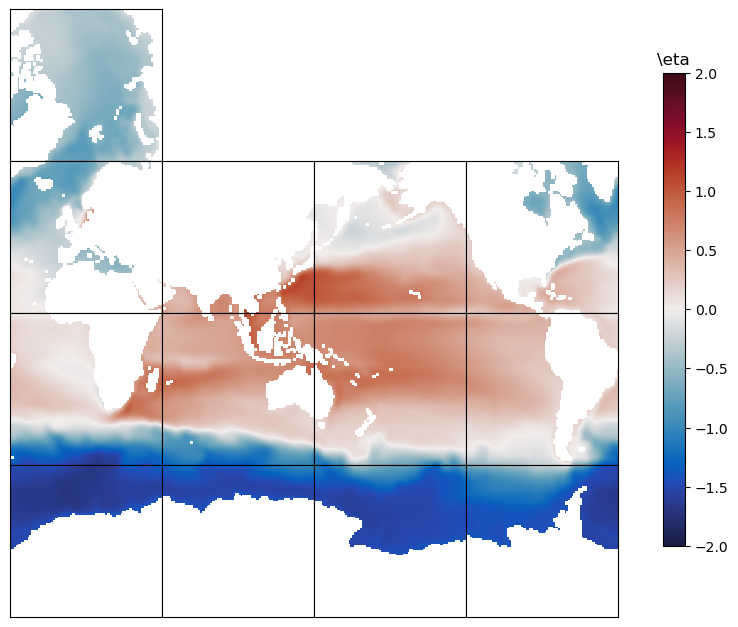

In [16]:

plt.figure(figsize=[14,6]);
ecco.plot_tiles(eta[0,:,:,:], show_colorbar=True, 
                cmin=-2, cmax=2, 
                cmap=cmocean.cm.balance, 
                rotate_to_latlon=True, layout='latlon',
               show_tile_labels=False);
plt.title('\eta')

# 3. steric component $- \frac{1}{\rho_0}\frac{H+\eta}{H}\int_{-H}^0{\rho'}dz* $

In [19]:
# ds_DEN.PHIHYDcR
rhoConst = 1029.

rho_zsum = (ds_DEN.RHOAnoma[itime,:,:,:] * ds_grid.drF * ds_grid.hFacC).sum(dim='k')
eta_s = - 1/rhoConst * (ds_grid.Depth + eta) / ds_grid.Depth * rho_zsum
eta_s_noeta = - 1/rhoConst * rho_zsum

eta_s = eta_s.transpose('time', 'tile', 'j', 'i')
# eta_s_noeta = eta_s_noeta.transpose('time', 'tile', 'j', 'i')

eta_s_noeta
# rho_zsum
# eta_s

<xarray.DataArray (time: 300, tile: 13, j: 90, i: 90)> Size: 126MB
dask.array<mul, shape=(300, 13, 90, 90), dtype=float32, chunksize=(2, 7, 45, 45), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2kB 1993-01-16T12:00:00 ... 2017-12-16T12:...
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12

In [20]:
eta_s

<xarray.DataArray (time: 300, tile: 13, j: 90, i: 90)> Size: 126MB
dask.array<transpose, shape=(300, 13, 90, 90), dtype=float32, chunksize=(2, 7, 45, 45), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
  * time     (time) datetime64[ns] 2kB 1993-01-16T12:00:00 ... 2017-12-16T12:...

Text(0.5, 1.0, '\\eta')

<Figure size 1400x600 with 0 Axes>

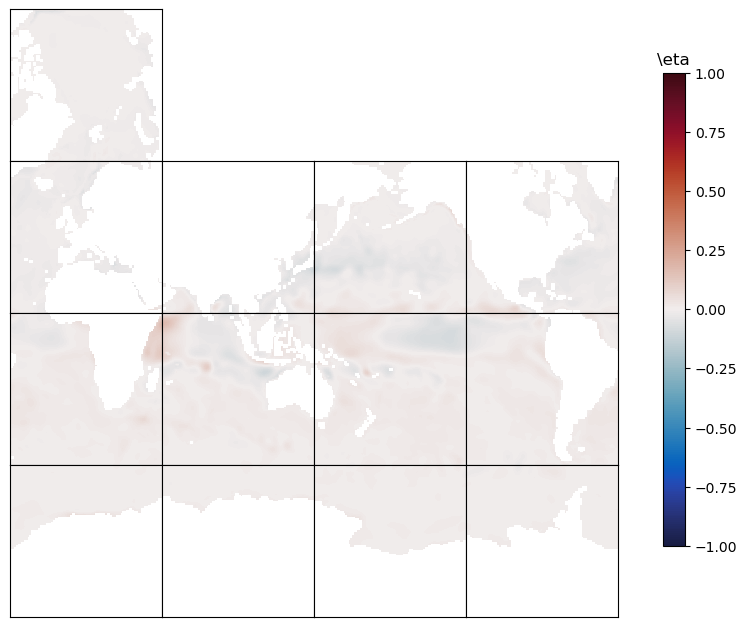

In [21]:
aa = eta_s[1,:,:,:] - eta_s[0,:,:,:]

plt.figure(figsize=[14,6])
ecco.plot_tiles(aa, show_colorbar=True, 
                cmin=-1, cmax=1, 
                cmap=cmocean.cm.balance, 
                rotate_to_latlon=True, layout='latlon',
               show_tile_labels=False)
plt.title('\eta')

In [22]:
eta_anom = eta - eta[0,:,:,:]
etam_anom = eta_m - eta_m[0,:,:,:]
etas_anom = eta_s - eta_s[0,:,:,:]
etasno_anom = eta_s_noeta - eta_s_noeta[0,:,:,:]
res = eta_anom - etam_anom - etas_anom

etasno_anom

<xarray.DataArray (time: 300, tile: 13, j: 90, i: 90)> Size: 126MB
dask.array<sub, shape=(300, 13, 90, 90), dtype=float32, chunksize=(2, 7, 45, 45), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2kB 1993-01-16T12:00:00 ... 2017-12-16T12:...
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12

Text(0.5, 1.0, 'SSH anamolies (reletive to t=0)')

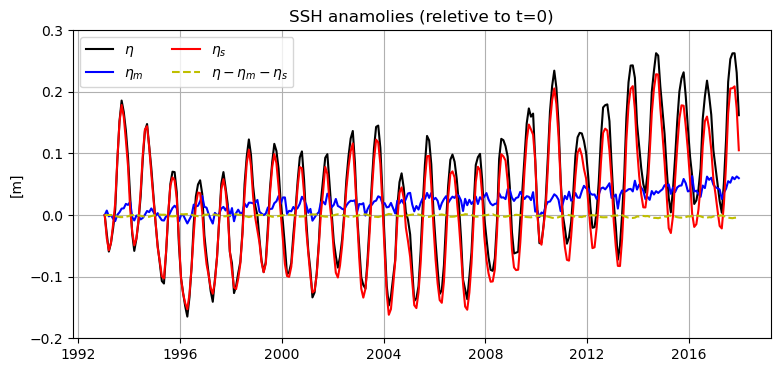

In [23]:
res = eta_anom - etam_anom - etas_anom

plt.figure(figsize=(9,4))
plt.plot(eta_anom['time'], eta_anom[:,10,66,55], label='$\eta$', color='k')

# plt.figure(figsize=(12,6))
plt.plot(etam_anom['time'], etam_anom[:,10,66,55], label='$\eta_m$', color='b')

# plt.figure(figsize=(12,6))
plt.plot(etas_anom['time'], etas_anom[:,10,66,55], label='$\eta_s$', color='r')
# plt.plot(etasno_anom['time'], etasno_anom[:,10,66,55], label='$\eta_s$-no', color='m')

plt.plot(res['time'], res[:,10,66,55], label='$\eta - \eta_m - \eta_s$', color='y', linestyle='--')

# plt.xlabel('')
plt.ylim(-.2, .3)
plt.ylabel('[m]')
plt.legend(ncol=2)
plt.grid(True) 
plt.title('SSH anamolies (reletive to t=0)')